In [1]:
import json
import random
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from pathlib import Path
from collections import defaultdict
from features.utils import build_mapping_to_ids

warnings.filterwarnings('ignore')

# Data

### Get all problems

In [2]:
dataset = pd.read_csv("data/java_2000_dataset_code.csv")

In [3]:
# Drop rows where null values exist in 'focal_class_code' or 'test_class_code'
dataset.dropna(subset=['focal_class_code', 'test_class_code'], inplace=True)

In [4]:
# dataset.head()

In [5]:
# dataset.info()

In [6]:
# dataset.isnull().sum()

In [7]:
print("<<<<<<<<<<<<<<<<<<<PART 1 FINISHED>>>>>>>>>>>>>>>>>>>>>>>>")

<<<<<<<<<<<<<<<<<<<PART 1 FINISHED>>>>>>>>>>>>>>>>>>>>>>>>


# Build dataset

In [8]:
from features import *
from sklearn.feature_selection import mutual_info_regression
import gc  # Garbage Collector interface

In [9]:
def codes_with_ids_builder(chunk):
    # Dummy function to represent your actual feature calculation
    # Replace this with your actual function
    return [{'repo_id': row['repo_id'], 'code': row['focal_class_code']} for _, row in chunk.iterrows()]

In [10]:
# 'dataset' is the large initial DataFrame
chunks = np.array_split(dataset, 10)
samplesdf = pd.DataFrame()

In [11]:
processed_frames = []  # To collect processed DataFrames
for chunk in chunks:
    codes_with_ids = codes_with_ids_builder(chunk)
    
    samples = calculate_features_for_files(codes_with_ids)
    
    # Convert the processed chunk to DataFrame and add to the list
    processed_frames.append(pd.DataFrame(samples))
    
    # Clean up to manage memory
    del chunk  # Delete the chunk to free memory
    gc.collect()  # Explicitly call garbage collection


In [12]:
# Concatenate all processed chunks into a single DataFrame
samplesdf = pd.concat(processed_frames, ignore_index=True)
print(samplesdf.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1914 entries, 0 to 1913
Columns: 109 entries, MaxDepthASTNode to whiteSpaceRatio
dtypes: float64(105), int64(4)
memory usage: 1.6 MB
None


In [13]:
# Clean up processed_frames list to free up memory
del processed_frames
gc.collect()

0

In [14]:
# codes = dataset['focal_class_code'].values  # Assuming 'code_column' is the name of your column with the code
"""
codes_with_ids = [{'repo_id': row['repo_id'], 'code': row['focal_class_code']} for index, row in dataset.iterrows()]

samples = calculate_features_for_files(codes_with_ids)
"""

"\ncodes_with_ids = [{'repo_id': row['repo_id'], 'code': row['focal_class_code']} for index, row in dataset.iterrows()]\n\nsamples = calculate_features_for_files(codes_with_ids)\n"

In [15]:
print("<<<<<<<<<<<<<<<<<<<PART 2 FINISHED>>>>>>>>>>>>>>>>>>>>>>>>")

<<<<<<<<<<<<<<<<<<<PART 2 FINISHED>>>>>>>>>>>>>>>>>>>>>>>>


### Minor EDA for samples

In [16]:
"""
samplesdf = pd.DataFrame(samples) 
"""

'\nsamplesdf = pd.DataFrame(samples) \n'

In [17]:
# import dask.dataframe as dd
# Convert the samples list to a Dask DataFrame
# samplesdf = dd.from_pandas(pd.DataFrame(samples), npartitions=10)  # Adjust npartitions based on your dataset and system

In [18]:
# samplesdf.shape

In [19]:
column_name = 'repo_id'
# Pop the column out of the DataFrame
desired_column = samplesdf.pop(column_name)
# Reinsert it at the beginning of the DataFrame
samplesdf.insert(0, column_name, desired_column)

In [20]:
# samplesdf.head()

In [21]:
# columns_to_check = [
#     "WordUnigramTF",
#     "In(numkeywords/length)",
#     "In(numTernary/length)",
#     "In(numTokens/length)",
#     "In(numComments/length)",
#     "In(numLiterals/length)",
#     "In(numKeywords/length)",
#     "In(numFunctions/length)",
#     "In(numMacros/length)",
#     "nestingDepth",
#     "branchingFactor",
#     "avgParams",
#     "stdDevNumParams",
#     "avgLineLength",
#     "stdDevLineLength",
#     "In(numTabs/length)",
#     "In(numSpaces/length)",
#     "In(numEmptyLines/length)",
#     "whiteSpaceRatio",
#     "newLineBeforeOpenBrace",
#     "tabsLeadLines",
#     "MaxDepthASTNode",
#     "ASTNodeBigramsTF",
#     "ASTNodeTypesTF",
#     "ASTNodeTypesTFIDF",
#     "ASTNodeTypeAvgDep",
#     "cppKeywords",
#     "CodeInASTLeavesTF",
#     "CodeInASTLeavesTFIDF",
#     "CodeInASTLeavesAvgDep"
# ]

# # Function to clean column names
# def clean_column_name(name):
#     return name.replace(" ", "").replace("In", "ln").lower()

# # Clean DataFrame column names
# samplesdf.columns = [clean_column_name(name) for name in samplesdf.columns]

# # Check each column
# for col in columns_to_check:
#     cleaned_col = clean_column_name(col)
#     if cleaned_col in samplesdf.columns:
#         print(f"Column '{col}' exists in the DataFrame.")
#     else:
#         print(f"Column '{col}' does NOT exist in the DataFrame.")

In [22]:
print("<<<<<<<<<<<<<<<<<<<PART 3 FINISHED>>>>>>>>>>>>>>>>>>>>>>>>")

<<<<<<<<<<<<<<<<<<<PART 3 FINISHED>>>>>>>>>>>>>>>>>>>>>>>>


## Build X and Y 

In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_regression
import numpy as np

In [24]:
y = samplesdf['repo_id']
X = samplesdf.drop(columns=['repo_id'])

In [25]:
X.fillna(0, inplace=True)
# X = X.fillna(0)
# y = y.fillna(0)

In [26]:
print("<<<<<<<<<<<<<<<<<<<PART 4 FINISHED>>>>>>>>>>>>>>>>>>>>>>>>")

<<<<<<<<<<<<<<<<<<<PART 4 FINISHED>>>>>>>>>>>>>>>>>>>>>>>>


### Select the best 1500 features according to mutual information

In [27]:
# Convert to numpy array for mutual information calculation if needed
X_np = X.to_numpy(dtype=np.float32)

# Replace inf/-inf with large finite numbers (if infinities are expected)
X_np = np.where(np.isinf(X_np), np.finfo(np.float32).max, X_np)

#--------------------

# X_small = X.compute()  # Converts the Dask DataFrame to a pandas DataFrame
# y_small = y.compute()

# X_small = X_small.replace([np.inf, -np.inf], np.finfo(np.float32).max)
# X_small[X_small > np.finfo(np.float32).max] = np.finfo(np.float32).max
# X_small[X_small < np.finfo(np.float32).min] = np.finfo(np.float32).min

# X_np = X_small.astype(np.float32).to_numpy()
# y_np = y_small.to_numpy()

In [28]:
print("<<<<<<<<<<<<<<<<<<<PART 5 FINISHED>>>>>>>>>>>>>>>>>>>>>>>>")

<<<<<<<<<<<<<<<<<<<PART 5 FINISHED>>>>>>>>>>>>>>>>>>>>>>>>


In [29]:
# Calculate mutual information
# mi = mutual_info_regression(X_np, y, random_state=0)
# mi /= np.max(mi)  # Normalize mutual information scores for better comparison

# # Select the top 1500 features
# mi_indices = np.argsort(mi)[-1500:]  # Get indices of top 1500 features
# selected_features = X.columns[mi_indices]  # Get feature names
# X = X[selected_features]  # Subset X to keep only selected features

# print(f'Number of samples: {X.shape[0]}')
# print(f'Number of features: {X.shape[1]}')

#------------------------
# # Calculate mutual information
# mi = mutual_info_regression(X_np, y.compute(), random_state=0)  # Ensure y is also prepared for this operation
# mi /= np.max(mi)  # Normalize mutual information scores for better comparison

# # Select the top 1500 features
# mi_indices = np.argsort(mi)[-1500:]  # Get indices of top 1500 features
# selected_features = X_small.columns[mi_indices]  # Get feature names
# X_selected = X_small[selected_features]  # Subset X to keep only selected features

# print(f'Number of samples: {X_selected.shape[0]}')
# print(f'Number of features: {X_selected.shape[1]}')


In [30]:
print("<<<<<<<<<<<<<<<<<<<PART 6 FINISHED>>>>>>>>>>>>>>>>>>>>>>>>")

<<<<<<<<<<<<<<<<<<<PART 6 FINISHED>>>>>>>>>>>>>>>>>>>>>>>>


In [31]:
X.head()

,MaxDepthASTNode,avgLineLength,avgParams,javaKeywords_abstract,javaKeywords_assert,javaKeywords_boolean,javaKeywords_break,javaKeywords_byte,javaKeywords_case,javaKeywords_catch,...,ln(num_transient/length),ln(num_try/length),ln(num_void/length),ln(num_volatile/length),ln(num_while/length),newLineBeforeOpenBrace,stdDevLineLength,stdDevNumParams,tabsLeadLines,whiteSpaceRatio
0,10,25.145833,0.500000,0.0,0.0,0.04,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,26.861520,0.500000,0,0.290123
1,7,28.187500,2.333333,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,30.402958,0.471405,0,0.211688
2,7,28.187500,2.333333,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,30.402958,0.471405,0,0.211688
3,7,28.187500,2.333333,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,30.402958,0.471405,0,0.211688
4,9,40.500000,1.500000,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,43.037774,0.500000,0,0.181017


In [32]:
X.isnull().all(axis=1).sum() # Rows with all columns null

0

In [33]:
X.isnull().sum()

MaxDepthASTNode           0
avgLineLength             0
avgParams                 0
javaKeywords_abstract     0
javaKeywords_assert       0
                         ..
newLineBeforeOpenBrace    0
stdDevLineLength          0
stdDevNumParams           0
tabsLeadLines             0
whiteSpaceRatio           0
Length: 108, dtype: int64

In [34]:
print("<<<<<<<<<<<<<<<<<<<PART 7 FINISHED>>>>>>>>>>>>>>>>>>>>>>>>")

<<<<<<<<<<<<<<<<<<<PART 7 FINISHED>>>>>>>>>>>>>>>>>>>>>>>>


# Classification

In [35]:
from sklearn.model_selection import train_test_split

In [36]:
# Find classes with more than one instance
class_counts = y.value_counts()
valid_classes = class_counts[class_counts > 1].index

# Filter your dataset
valid_indices = y[y.isin(valid_classes)].index
X_filtered = X.loc[valid_indices]
y_filtered = y.loc[valid_indices]

In [37]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_filtered, test_size=0.2, random_state=42, stratify=y_filtered)

In [38]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [39]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Initialize the Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf.fit(X_train, y_train)

# Predict on the test set
y_pred = rf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {accuracy:.4f}')

Test Accuracy: 0.9869


In [40]:
print("<<<<<<<<<<<<<<<<<<<PART 8 FINISHED>>>>>>>>>>>>>>>>>>>>>>>>")

<<<<<<<<<<<<<<<<<<<PART 8 FINISHED>>>>>>>>>>>>>>>>>>>>>>>>


## Saving the trained model

In [41]:
import pickle
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [42]:
# Save the trained model to a file
model_filename = 'models/2000_dataset_model.pkl'

with open(model_filename, 'wb') as file:
    pickle.dump(rf, file)

print(f'Model saved successfully to {model_filename}')

Model saved successfully to models/2000_dataset_model.pkl


# Validation

### Cross-Validation

In [43]:
from sklearn.model_selection import cross_val_score

# Perform 5-fold cross-validation
cv_scores = cross_val_score(rf, X, y, cv=5)

print("CV Accuracy Scores:", cv_scores)
print("CV Accuracy: %0.2f (+/- %0.2f)" % (cv_scores.mean(), cv_scores.std() * 2))

CV Accuracy Scores: [0.99477807 0.98694517 0.98172324 0.96866841 0.97643979]
CV Accuracy: 0.98 (+/- 0.02)


### Precision, Recall, and F1 Score

In [44]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

     6766558       1.00      0.97      0.99        35
    16611556       1.00      1.00      1.00        35
    17898911       0.99      1.00      0.99        68
    34861263       1.00      1.00      1.00         1
    41263775       0.98      1.00      0.99        55
    41307987       1.00      1.00      1.00         3
    42557838       0.97      0.97      0.97        29
    44512524       1.00      0.97      0.99        80
    58314354       1.00      1.00      1.00         1
    59021106       1.00      0.80      0.89         5
    59801168       1.00      1.00      1.00         1
    81368488       0.97      1.00      0.99        37
   102814088       1.00      1.00      1.00         4
   173924701       1.00      1.00      1.00         1
   181421086       0.96      1.00      0.98        26
   183214896       1.00      1.00      1.00         1
   188705852       1.00      1.00      1.00         1

    accuracy              

### ROC Curve and AUC Score

In [45]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize

# Binarize y_test and y_pred for multi-class ROC AUC calculation
y_test_binarized = label_binarize(y_test, classes=np.unique(y))
y_pred_proba = rf.predict_proba(X_test)

# Compute AUC
roc_auc = roc_auc_score(y_test_binarized, y_pred_proba, multi_class="ovr")

print("ROC AUC Score:", roc_auc)

# For plotting ROC curves for each class, you'd iterate through classes and calculate ROC curve per class

ROC AUC Score: 0.9999648300210002


### Feature Importances

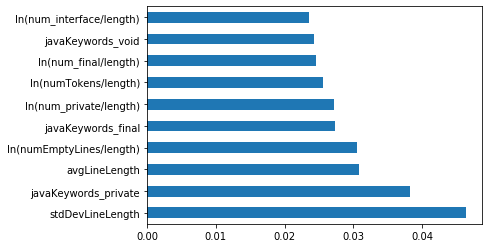

None


In [46]:
feature_importances = pd.Series(rf.feature_importances_, index=X.columns)
feature_importances.nlargest(10).plot(kind='barh')  # Top 10 features
print(plt.show())